<a href="https://colab.research.google.com/github/tomPlus353/miyagi_house_price_prediction/blob/main/house_price_neural_net(kaggle).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd ..
%ls

Mounted at /gdrive
/
bin@      etc/     lib64@                    opt/         sbin@   usr/
boot/     gdrive/  libx32@                   proc/        srv/    var/
content/  home/    media/                    python-apt/  sys/
datalab/  lib@     mnt/                      root/        tmp/
dev/      lib32@   NGC-DL-CONTAINER-LICENSE  run/         tools/


In [3]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# load data
with open("gdrive/MyDrive/Colab_Notebooks/04.csv") as f:
    data = pd.read_csv(f)

# select categorical and numerical features
# cat_cols = ['DistrictName', 
#             'NearestStation', 'FloorPlan', 'LandShape', 'Structure', 'Use', 
#             'Purpose', 'Direction', 'Classification', 'CityPlanning', 'Renovation', 'Remarks', 'MunicipalityCode',  'TimeToNearestStation'
#             ]
cat_cols = [
   'MunicipalityCode',
    'DistrictName',
    # 'Region',
    # 'NearestStation',
    # 'CityPlanning',
            ]

num_cols = [
            'Area', 
            'TotalFloorArea', 
            'BuildingYear', 
            'CoverageRatio', 
            'FloorAreaRatio', 
            'MaxTimeToNearestStation',
            'MinTimeToNearestStation',
            # 'Year', 
            # 'Quarter',
            # 'Breadth', 
            # 'Frontage',
            ]

# only target houses
data = data[data["Type"] == "Residential Land(Land and Building)"]

# Replace missing values with the mean of the column
data.fillna(data.mean(), inplace=True)

# drop nan values
data.dropna(subset=num_cols, inplace=True)




<ipython-input-4-eb8b938d29a9>:12: DtypeWarning: Columns (12,26,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(f)
<ipython-input-4-eb8b938d29a9>:45: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


In [5]:

# check the data type of each column
print(data.dtypes)
print(data.describe)

data.head()

# # select rows 0 to 4 and columns 12, 26, and 3
#subset = data.iloc[0:5, [12, 26, 36]]

# # print the subset of data
#print(subset)


No                               int64
Type                            object
Region                          object
MunicipalityCode                 int64
Prefecture                      object
Municipality                    object
DistrictName                    object
NearestStation                  object
TimeToNearestStation            object
MinTimeToNearestStation        float64
MaxTimeToNearestStation        float64
TradePrice                       int64
FloorPlan                      float64
Area                             int64
AreaIsGreaterFlag                int64
UnitPrice                      float64
PricePerTsubo                  float64
LandShape                       object
Frontage                       float64
FrontageIsGreaterFlag             bool
TotalFloorArea                 float64
TotalFloorAreaIsGreaterFlag      int64
BuildingYear                   float64
PrewarBuilding                   int64
Structure                       object
Use                      

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
2,3,Residential Land(Land and Building),Residential Area,4101,Miyagi Prefecture,"Aoba Ward,Sendai City",Aobamachi,Kitasendai,8,8.0,...,City Road,4.0,Category II Residential Zone,60.0,200.0,1st quarter 2018,2018,1,NaN,NaN
9,10,Residential Land(Land and Building),Residential Area,4101,Miyagi Prefecture,"Aoba Ward,Sendai City",Aobamachi,Kitasendai,8,8.0,...,Private Road,4.5,Category II Residential Zone,60.0,200.0,1st quarter 2015,2015,1,NaN,Dealings including private road
11,12,Residential Land(Land and Building),Residential Area,4101,Miyagi Prefecture,"Aoba Ward,Sendai City",Akasaka,Ayashi,30-60minutes,30.0,...,City Road,6.0,Category I Exclusively Low-story Residential Zone,40.0,60.0,2nd quarter 2019,2019,2,NaN,NaN
13,14,Residential Land(Land and Building),Residential Area,4101,Miyagi Prefecture,"Aoba Ward,Sendai City",Akasaka,Ayashi,30-60minutes,30.0,...,City Road,16.0,Category I Residential Zone,60.0,200.0,1st quarter 2019,2019,1,NaN,NaN
15,16,Residential Land(Land and Building),Residential Area,4101,Miyagi Prefecture,"Aoba Ward,Sendai City",Akasaka,Ayashi,30-60minutes,30.0,...,City Road,16.0,Category I Residential Zone,60.0,200.0,3rd quarter 2018,2018,3,NaN,NaN


                             Area  TotalFloorArea  BuildingYear  \
Area                     1.000000        0.584216     -0.227761   
TotalFloorArea           0.584216        1.000000     -0.135320   
BuildingYear            -0.227761       -0.135320      1.000000   
CoverageRatio            0.154136        0.235321     -0.103564   
FloorAreaRatio           0.117991        0.309899     -0.083052   
MaxTimeToNearestStation  0.057138       -0.081506     -0.020527   
MinTimeToNearestStation  0.133151       -0.061568     -0.055991   
TradePrice               0.286034        0.527374      0.031100   

                         CoverageRatio  FloorAreaRatio  \
Area                          0.154136        0.117991   
TotalFloorArea                0.235321        0.309899   
BuildingYear                 -0.103564       -0.083052   
CoverageRatio                 1.000000        0.876879   
FloorAreaRatio                0.876879        1.000000   
MaxTimeToNearestStation      -0.394145       -0.

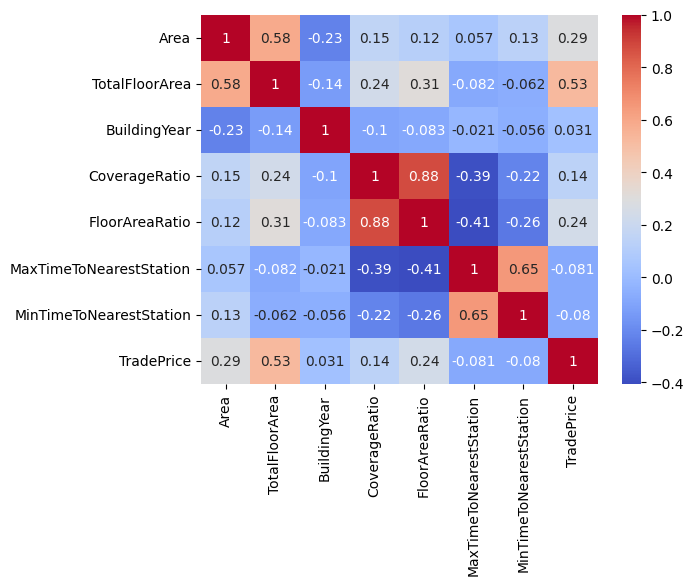

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(16,5))
# fig.add_subplot(2,2,1)
# sns.scatterplot(data['Area'])
# fig.add_subplot(2,2,2)
# sns.scatterplot(data['TotalFloorArea'])
# fig.add_subplot(2,2,3)
# sns.scatterplot(data['BuildingYear'])
# fig.add_subplot(2,2,3)
# sns.scatterplot(data['TradePrice'])

def showCorrelation(df, columns, target):
  columns.append(target)
  # calculate the correlation matrix for the selected columns
  corr_matrix = df[columns].corr()

  # print the correlation matrix
  print(corr_matrix)

  # visualize the correlation matrix using a heatmap
  sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

showCorrelation(data, num_cols,'TradePrice')

In [7]:
# for col in data.columns:
#     print(f"Unique values for column {col}:")
#     print(len(data[col].unique()))

In [8]:
## created new unique location including district and municipality
data['DistrictName'] = data['DistrictName'].astype('str') + data['MunicipalityCode'].astype('str')

In [9]:
# for col in data.columns:
#     print(f"Unique values for column {col}:")
#     print(len(data[col].unique()))

In [10]:
checkpoint_path = "gdrive/MyDrive/Colab_Notebooks/training_1/cp.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

In [ ]:
# one-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(data[cat_cols])
encoded_cat = encoder.transform(data[cat_cols]).toarray()

# standardize numerical features
scaler = StandardScaler()
scaled_num = scaler.fit_transform(data[num_cols])

# combine encoded categorical and scaled numerical features
X = np.hstack((encoded_cat, scaled_num))

# define target variable
y = data['TradePrice']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

# define model
model = Sequential()
model.add(Dense(X_train.shape[1], activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(X_train.shape[1] / 2, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1))

# compile model
model.compile(loss='mae', optimizer='adam')

# early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train model
with tf.device('/GPU:0'):  # Use the first GPU
  model.fit(X_train, 
            y_train,
            epochs=100, 
            validation_data=(X_test, y_test), 
            callbacks=[early_stop,cp_callback])

# evaluate model
mae = model.evaluate(X_test, y_test)
print(f"Mean average Error: {mae:.2f}")

# make predictions
y_pred = model.predict(X_test)


(23212, 1435)
Epoch 1/100
725/726 [============================>.] - ETA: 0s - loss: 35703232.0000
Epoch 1: saving model to gdrive/MyDrive/Colab_Notebooks/training_1/cp.ckpt
726/726 [==============================] - 60s 80ms/step - loss: 35698592.0000 - val_loss: 34267168.0000
Epoch 2/100
726/726 [==============================] - ETA: 0s - loss: 27819964.0000
Epoch 2: saving model to gdrive/MyDrive/Colab_Notebooks/training_1/cp.ckpt
726/726 [==============================] - 40s 56ms/step - loss: 27819964.0000 - val_loss: 23263142.0000
Epoch 3/100
726/726 [==============================] - ETA: 0s - loss: 20965610.0000
Epoch 3: saving model to gdrive/MyDrive/Colab_Notebooks/training_1/cp.ckpt
726/726 [==============================] - 42s 58ms/step - loss: 20965610.0000 - val_loss: 20895134.0000
Epoch 4/100
726/726 [==============================] - ETA: 0s - loss: 19476856.0000
Epoch 4: saving model to gdrive/MyDrive/Colab_Notebooks/training_1/cp.ckpt
726/726 [======================

In [ ]:
avg = y_test.mean()
print(f"Mean absolute error as percentage of average price: {(mae/avg)*100}%")